In [250]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Set display options to show more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column


### <font color="orange">  **Data Loading, Preprocessing** </font>

In [251]:
df = pd.read_csv('health_insurance_train.csv')
df_autograder = pd.read_csv('health_insurance_autograde.csv')
pd.options.display.float_format = '{:.2f}'.format

# Define a function to convert education ranges to numerical values
def convert_education(education):

    education = education.replace('years', '')

    if '>16' in education:
        return 20
    
    if '<9' in education:
        return 4.5

    education = education.split('-')
    education = (float(education[-1])+float(education[0]))/2

    return education

# Define a function to convert yes/no values to binary values
def yes_no_True_False_to_binary(value):
    if value == 'yes' or value == 'no':
        if value == 'yes':
            return 1
        else:
            return -1
        
    if value == True or value == False:
        if value == True:
            return 1
        else:
            return 0

    return value

# Define a function to convert NaN values to the mean of the column
def nan_to_mean(value, mean):
    if pd.isna(value):
        return mean
    return value

# Define a function apply all conversion functions to the dataframe
def preprocess_data(df):
    # Apply the conversion functions to the education column
    df['education'] = df['education'].apply(convert_education)

    # Apply one-hot encoding to the race and region column

    ''''
    One hot encoding is a process by which categorical variables are converted into
    binary True/False. ML algorithm will read True as 1 and False as 0. So gradients
    can be made for each column separetely.

    '''
    df = pd.get_dummies(df, columns=['race'], prefix='race')
    df = pd.get_dummies(df, columns=['region'],prefix='reg')
    df = pd.get_dummies(df, columns=['hispanic'],prefix='hisp')


    # Apply binary conversion to all remaining columns that contain yes/no or True/False values
    for key in df.keys():
        df[key] = df[key].apply(yes_no_True_False_to_binary)

    # Apply the mean conversion to all columns that contain NaN values
    ''''
    Now that all columns are already converted to numerical values, we can apply the
    mean conversion to all columns that contain NaN values.

    '''

    for key in df:
        mean = df[key].mean()
        df[key] = df[key].apply(lambda x: nan_to_mean(x, mean))

    return df

df_pp = preprocess_data(df)
df_autograder_pp = preprocess_data(df_autograder)

In [252]:
df_pp.head()

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,40.00,-1,1,1,14.00,17.00,0.00,1.00,22.00,0,0,1,0,0,1,0,1,0
1,40.00,-1,1,1,14.00,4.00,1.00,0.00,15.00,0,0,1,0,0,1,0,1,0
2,0.00,1,-1,1,16.00,21.00,0.00,1.00,100.00,0,0,1,0,1,0,0,1,0
3,40.00,-1,-1,1,14.00,22.00,0.34,0.70,60.00,0,0,1,1,0,0,0,1,0
4,35.00,-1,1,-1,12.00,15.00,0.00,2.00,0.00,0,0,1,0,0,1,0,1,0


In [253]:
df_autograder_pp.head()

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,16.00,25.00,0.00,0.00,0.00,0,0,1,0,0,0,1,1,0
1,-1,-1,-1,12.00,41.00,0.00,0.00,0.00,0,0,1,0,0,1,0,1,0
2,1,1,1,20.00,21.00,0.00,2.00,34.30,0,0,1,0,1,0,0,1,0
3,-1,1,1,10.00,46.50,0.00,0.00,0.00,0,0,0,0,1,0,0,1,0
4,-1,-1,-1,14.00,9.00,0.00,0.00,25.00,0,0,1,1,0,0,0,1,0


In [254]:
########### Pipeline Configuration ##############

specific_scaling = True
filter_outliers = True

#Pipeline 1 --> False,False
#Pipeline 2 --> True,True
#################################################


### <font color="orange">  **Scaling** </font>

In [255]:
df_pp_mean = df_pp.mean(axis=0)
df_pp_std = df_pp.std(axis=0)

Y_mean = df_pp_mean[0]
Y_std = df_pp_std[0]

if specific_scaling:
    def scale_specifically(df, mean, std, columns_index=[0, 4, 5, 6, 7, 8]):
        df_scaled = df.copy()
        for i in range(len(df.columns)):
            if i in columns_index:
                df_scaled.iloc[:, i] = (df_scaled.iloc[:, i] - mean.iloc[i]) / std.iloc[i]
        return df_scaled


    df_scaled = scale_specifically(df_pp, df_pp_mean, df_pp_std, columns_index=[0, 4, 5, 6, 7, 8])
    df_autograder_scaled = scale_specifically(df_autograder_pp, df_pp_mean.iloc[1:], df_pp_std.iloc[1:], columns_index=[3,4,5,6,7])

else:
    df_scaled = (df_pp - df_pp_mean) / df_pp_std
    df_autograder_scaled = (df_autograder_pp - df_pp_mean.iloc[1:]) / df_pp_std.iloc[1:]

C:\Users\yanca\AppData\Local\Temp\ipykernel_29596\1981104028.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_mean = df_pp_mean[0]
C:\Users\yanca\AppData\Local\Temp\ipykernel_29596\1981104028.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_std = df_pp_std[0]


In [256]:
df_scaled.head()

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,0.77,-1,1,1,0.28,-0.51,-0.55,0.31,-0.22,0,0,1,0,0,1,0,1,0
1,0.77,-1,1,1,0.28,-1.63,1.07,-0.75,-0.52,0,0,1,0,0,1,0,1,0
2,-1.37,1,-1,1,0.92,-0.16,-0.55,0.31,3.06,0,0,1,0,1,0,0,1,0
3,0.77,-1,-1,1,0.28,-0.08,0.00,-0.00,1.38,0,0,1,1,0,0,0,1,0
4,0.50,-1,1,-1,-0.36,-0.68,-0.55,1.37,-1.15,0,0,1,0,0,1,0,1,0


In [257]:
df_autograder_scaled.head()

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,0.92,0.18,-0.55,-0.75,-1.15,0,0,1,0,0,0,1,1,0
1,-1,-1,-1,-0.36,1.57,-0.55,-0.75,-1.15,0,0,1,0,0,1,0,1,0
2,1,1,1,2.20,-0.16,-0.55,1.37,0.30,0,0,1,0,1,0,0,1,0
3,-1,1,1,-0.99,2.04,-0.55,-0.75,-1.15,0,0,0,0,1,0,0,1,0
4,-1,-1,-1,0.28,-1.20,-0.55,-0.75,-0.10,0,0,1,1,0,0,0,1,0


   whrswk  hhi  whi  hhi2  education  experience  kidslt6  kids618  husby  \
0    0.77   -1    1     1       0.28       -0.51    -0.55     0.31  -0.22   
1    0.77   -1    1     1       0.28       -1.63     1.07    -0.75  -0.52   
2   -1.37    1   -1     1       0.92       -0.16    -0.55     0.31   3.06   
3    0.77   -1   -1     1       0.28       -0.08     0.00    -0.00   1.38   
4    0.50   -1    1    -1      -0.36       -0.68    -0.55     1.37  -1.15   

   race_black  race_other  race_white  reg_northcentral  reg_other  reg_south  \
0           0           0           1                 0          0          1   
1           0           0           1                 0          0          1   
2           0           0           1                 0          1          0   
3           0           0           1                 1          0          0   
4           0           0           1                 0          0          1   

   reg_west  hisp_no  hisp_yes  mahalanobis  
0   

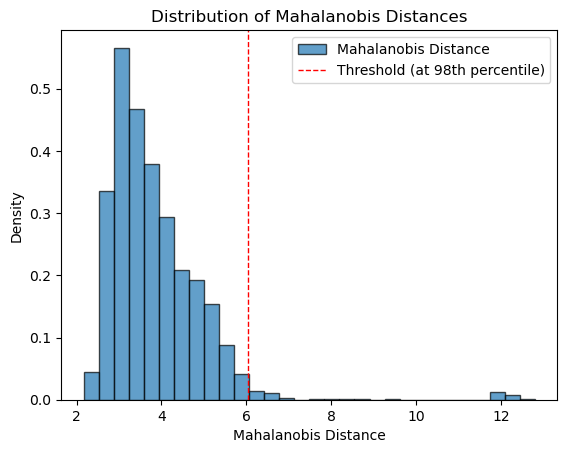

Outliers found
Number of outliers: 100


In [258]:
if filter_outliers:
    
    df_filtered = df_scaled.copy()
    df_numeric = df_scaled.select_dtypes(include=[np.number]) # Select only numerical columns

    # Calculate the mean vector and covariance matrix
    mean_vector = df_numeric.mean(axis=0)
    cov_matrix = np.cov(df_numeric.values.T)

    # Add a small regularization term to the covariance matrix such that it's not singular
    # Since we are using classification data, 
    regularization_term = 1e-5 * np.eye(cov_matrix.shape[0])
    cov_matrix += regularization_term


    #--------- Compute the Mahalanobis distance for each observation
    def mahalanobis_distance(row, mean_vector, cov_matrix):

        '''
        The Mahalanobis distance assumes that the data follows a multivariate normal distribution. 

        1. Calculate the difference vector (diff) between the observation and the mean.
        2. Transpose the difference vector (diff.T).
        3. Multiply the transposed difference vector by the inverse covariance matrix (diff.T @ inv_cov_matrix).
        4. Multiply the result by the original difference vector (diff.T @ inv_cov_matrix @ diff).
        5. Take the square root of the result to get the Mahalanobis distance (md).
        '''

        diff = row - mean_vector
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        md = np.sqrt(diff.T @ inv_cov_matrix @ diff) 
        return md

    # Apply the Mahalanobis distance function to each row
    # lamda makes row is a anonymous function that takes a single argument row, it is necessary to pass row as an argument to .apply
    # What apply sees is a function that takes a single argument, so it passes each row to this function
    df_filtered['mahalanobis'] = df_numeric.apply(lambda row: mahalanobis_distance(row, mean_vector, cov_matrix), axis=1) 
    print(df_filtered.head())

    #--------- Determine the threshold for identifying outliers
    percentile = 98
    threshold = np.percentile(df_filtered['mahalanobis'], percentile)
    print(f"Threshold (at {percentile}th percentile): {threshold}")


    # Plot the distribution of Mahalanobis distances
    plt.hist(df_filtered['mahalanobis'], bins=30, edgecolor='k', alpha=0.7, density=True, label='Mahalanobis Distance')

    # Add the threshold line
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold (at {percentile}th percentile)')

    # Add titles and labels
    plt.title('Distribution of Mahalanobis Distances')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Identify outliers
    outliers = df_filtered[df_filtered['mahalanobis'] > threshold]
    
    if not outliers.empty:
        print("Outliers found")
        print(f"Number of outliers: {len(outliers)}")
    else:
        print("No outliers found")
    
    # Filter out the rows that contain outliers
    df_filtered = df_filtered[df_filtered['mahalanobis'] <= threshold]

    # Drop the 'mahalanobis' column as it's no longer needed
    df_filtered.drop(columns=['mahalanobis'], inplace=True)

else: 
    df_filtered = df_scaled


In [259]:
from sklearn.model_selection import train_test_split

X = df_filtered.iloc[:, 1:]
Y = df_filtered.iloc[:, 0]



X_seen, X_unseen, Y_seen, Y_unseen = train_test_split(X, Y, test_size=0.2, random_state=42)
X_autograder = df_autograder_scaled

print(Y_seen)


4762    0.77
1979    0.50
3465   -1.37
859     0.77
2630   -1.37
4699    0.77
3758    0.77
4704   -1.37
2217    0.77
2391   -1.37
215     1.03
3187    0.66
87      0.77
3708    0.77
1053   -0.30
3658    0.61
693    -1.37
4076   -1.37
2758    0.77
1148    0.77
4353    0.77
577    -0.57
3616    0.77
2414   -1.37
1563    0.77
3523   -1.37
694     0.77
845     1.62
1149   -0.30
2615   -0.41
4219   -0.30
3632   -1.37
4273   -1.37
2569    0.77
1057   -0.84
1179   -1.37
183    -1.37
3628    0.77
440     0.77
2083   -1.37
295     0.23
2677    0.77
4250    1.30
1020   -0.04
547    -1.37
3902    0.66
192     1.03
2139    0.50
3852   -0.04
1662    0.50
276     0.77
4745    0.77
4012    1.30
3795    0.77
3638    1.67
114    -1.37
3507   -0.30
225    -0.94
641    -1.11
1123    0.77
3304   -0.09
2849   -1.37
806     0.77
4802    1.30
471     0.77
4400   -1.37
563    -1.37
4190   -0.30
2603    0.77
202     0.77
2546    0.23
410    -1.37
3005   -1.37
4391    0.77
4767    0.77
2072   -0.30
1589    0.71

### <font color="orange">  **Dummy model** </font>

In [260]:
from sklearn.dummy import DummyRegressor

def train_dummy_predictor(X, Y):
    model = DummyRegressor(strategy='mean')
    model.fit(X, Y)
    return model

### <font color="orange">  **KNN** </font>

In [261]:
from sklearn.neighbors import KNeighborsRegressor

def train_knn_regressor(X, Y, param_grid):
    model = KNeighborsRegressor(**param_grid)
    model.fit(X, Y)
    Y_pred = model.predict(X)
    loss_values = [mean_absolute_error(Y, Y_pred)]
    return model,loss_values

### <font color="orange">  **SGD** </font>

In [262]:
from sklearn.linear_model import SGDRegressor

def train_sgd_regressor(X, Y, params):
    model = SGDRegressor(**params)

    # penaulty = the regularization term to prevent overfitting
    # alpha = the learning rate
    # max_iter = the number of iterations to run the model
    # warm_start = allows the model to continue training from the previous iteration
    # tol = the stopping criterion

    # List to store the loss values
    loss_values = []
    
    epochs = 300
    for epoch in range(epochs):
        model.partial_fit(X, Y)
        Y_pred = model.predict(X)
        epoch_loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(epoch_loss)
    
    return model, loss_values

### <font color="orange">  **Regression Trees** </font>

In [263]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

def train_decision_tree_regressor(X, Y, params):

    '''params : dict
        Dictionary of parameters to pass to DecisionTreeRegressor.'''
    
    # splitter = Supported strategies are "best" to choose the best split and "random" to choose the best random split.
    # max_features = The number of features to consider when looking for the best split
    # min_samples_split = The minimum number of samples required to split an internal node
    # min_samples_leaf = The minimum number of samples required to be at a leaf node

    model = DecisionTreeRegressor(**params)
    loss_values = []
    
    # Custom training loop with logging
    for depth in range(1, params['max_depth'] + 1):
        model.set_params(max_depth=depth)
        model.fit(X, Y)
        Y_pred = model.predict(X)
        loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(loss)
    
    return model, loss_values

### <font color="orange">  **Esemble training** </font>

In [264]:

def grid_search(X, Y, model, param_grid, cv=5):
    
    # cv = It determines the cross-validation splitting strategy used to evaluate the performance of the model for each combination of hyperparameters
    # This means that the dataset will be split into 5 parts (folds). The model will be trained on 4 parts and tested on the remaining part.
    # This process will be repeated 5 times, each time with a different part as the test set.
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    # Fit the model
    print("Working on grid search")
    grid_search.fit(X, Y)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best parameters: {best_params}")
    
    return best_model, best_params


def train_models(X_seen,Y_seen,param_grid, model, model_train_function, n_models = 10, val_size = 0.2):

    models_training_loss = []
    model_list = []

    # Use grid search to find the best hyperparameters only once
    best_model, best_param = grid_search(X_seen, Y_seen, model, param_grid, cv=5)

    for n in range(n_models):
        
        X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size= val_size, random_state= 42*n)

        print(f"Training model {n+1}")
        model, loss_values = model_train_function(X_train, Y_train, best_param)

        model_list.append(model)
        models_training_loss.append(loss_values)


        Y_pred = model.predict(X_val)
        loss = mean_absolute_error(Y_val, Y_pred)

        print(f"Val Loss: {loss:.4f}")
    
    return model_list, models_training_loss


### <font color="orange">  **Esemble validation** </font>

In [265]:
print(f"Max Y_seen value: {Y_seen.max()}")
print(f"Min Y_seen value: {Y_seen.min()}")
print(f"Mean Y_seen value: {Y_seen.mean()}")
print("\n")


#############################
# ------ DUMMY PREDICTOR

X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size=0.2, random_state=42)
model = train_dummy_predictor(X_train, Y_train)
Y_pred = model.predict(X_val)

loss = mean_absolute_error(Y_val, Y_pred)
print(f"Dummy Predictor - Val Loss: {loss:.4f}")

############################



Max Y_seen value: 3.1178705210175255
Min Y_seen value: -1.372319745743416
Mean Y_seen value: -0.0010444383288136284


Dummy Predictor - Val Loss: 0.9237


Working on grid search
Best parameters: {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'penalty': 'l2'}
Training model 1
Val Loss: 0.6446
Training model 2
Val Loss: 0.6610
Training model 3
Val Loss: 0.6517
Training model 4
Val Loss: 0.6403
Training model 5
Val Loss: 0.6401
Training model 6
Val Loss: 0.6655
Training model 7
Val Loss: 0.6484
Training model 8
Val Loss: 0.6602
Training model 9
Val Loss: 0.6620
Training model 10
Val Loss: 0.6530


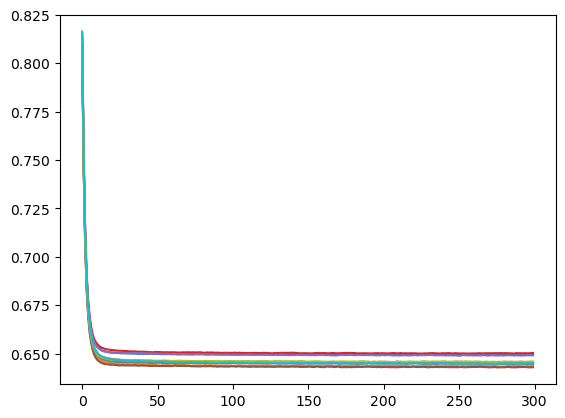

In [266]:
#############################
# ------SGD REGRESSOR

param_grid_SGD = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.00001,0.0001]
}

model = SGDRegressor()
model_list_SGD, models_training_loss = train_models(X_seen, Y_seen, param_grid_SGD, model, train_sgd_regressor)
##############################

for loss_values in models_training_loss:
    plt.plot(loss_values)


In [267]:
#############################
# ------KNN REGRESSOR
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

model = KNeighborsRegressor()
model_list_KNN, models_training_loss = train_models(X_seen, Y_seen, param_grid_KNN, model, train_knn_regressor)

print(models_training_loss)

##############################

Working on grid search
Best parameters: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Training model 1
Val Loss: 0.5980
Training model 2
Val Loss: 0.6402
Training model 3
Val Loss: 0.6202
Training model 4
Val Loss: 0.6174
Training model 5
Val Loss: 0.6211
Training model 6
Val Loss: 0.6444
Training model 7
Val Loss: 0.6094
Training model 8
Val Loss: 0.6203
Training model 9
Val Loss: 0.6126
Training model 10
Val Loss: 0.6118
[[0.572201489856707], [0.5570279075876368], [0.5635640769106494], [0.5677231756453496], [0.567436501552235], [0.5572789411178236], [0.5624530211011187], [0.568336813163584], [0.5681508624004826], [0.5650020961452998]]


### <font color="orange">  **Esemble test** </font>

In [270]:
def esemble_test(model_list, X_unseen, Y_unseen):
    loss_list = []
    for model in model_list:
        Y_pred = model.predict(X_unseen)
        loss_list.append(mean_absolute_error(Y_unseen, Y_pred))
    
    avg_loss = np.mean(loss_list)
    return avg_loss



KNN_avg_test_loss = esemble_test(model_list_KNN, X_unseen, Y_unseen)
print(f"KNN - Test Loss: {KNN_avg_test_loss:.4f}")

SGD_avg_test_loss = esemble_test(model_list_SGD, X_unseen, Y_unseen)
print(f"SGD - Test Loss: {SGD_avg_test_loss:.4f}")




    

[0.6109052816886221, 0.6036160117750492, 0.6078903999828723, 0.6067994888393444, 0.6089168481951918, 0.613761485409859, 0.6052027916201808, 0.614182973806222, 0.6066209761067671, 0.6104937106662913]
KNN - Test Loss: 0.6088
[0.6500011249487622, 0.6482606223504964, 0.6473687945801238, 0.6490937453420023, 0.6479147660846845, 0.6478685365244483, 0.6483507753724436, 0.6483288087623047, 0.6486346188782832, 0.6478891679638813]
SGD - Test Loss: 0.6484
